# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle
# plt.cm.tab20.colors

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

### Style settings

In [2]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

colors = cycle(mcolors.XKCD_COLORS.keys())
# mcolors.__dict__
# colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")

register_cmaps()
#plt.rcParams['image.cmap'] = 'emct8'
#plt.rcParams['image.cmap'] = 'warm'
plt.rcParams['image.cmap'] = 'YlOrRd'
#plt.rcParams['image.cmap'] = 'twilight'
#plt.rcParams['image.cmap'] = 'coolwarm'
#plt.rcParams['image.cmap'] = 'RdYlBu_r'
        

### General graphing functions

In [34]:
cluster_similarity_threshold = .4 
nskip = 10 # Time snapshot skips for cluster finding. = 5 secs
vmax = 40 # Max colorbar value in kymographs
tree_length = 30 # min length of a cluster tree in time snapshots. = 15 sec

In [4]:
def kymo_and_cluster_graph(sim_path):
    h5_contact_file = sim_path / 'analysis/contact_analysis.h5'

    fig, axarr = plt.subplots(1,1, figsize=(10, 6))
    _ = axarr.set_ylim(0, 1600)

    with h5py.File(h5_contact_file, 'r') as h5_data:
        time_arr = h5_data['time'][...]
        contact_kymo = h5_data['contact_kymo'][...]
    
        cgf.plot_contact_kymo(fig, axarr, time_arr, contact_kymo, vmax=vmax)


# Cluster analysis
    h5_clust_file = sim_path / 'analysis/cluster_analysis.h5'
    with h5py.File(h5_clust_file, 'r') as h5_data:
        cluster_grp = h5_data['clusters']
        time_arr = h5_data['time'][...]
        time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
        clusters = []
        for tg in time_grp_list:
            clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]
    t4 = time.time()
    root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

    trees = []
    tree_id_gen = aa.helpers.gen_id()
    for root in root_clusters:
        tree = cla.ClusterTree(next(tree_id_gen))
        tree.add_recursive(root)
        trees += [tree]

    fig, axarr = plt.subplots(1,2, figsize=(16, 6))

# Graph all clusters
    for tree, color in zip(trees, colors):
        if len(tree.clusters) < tree_length:
            continue
        for clust in tree.clusters:
            _ = axarr[0].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = color, markersize= .1, marker='.', linestyle='None')

# Graph largest branch
    biggest_tree = max(trees, key=lambda x: x.get_main_clust_branch()[0].mass_hist)
    biggest_tree.update_branch_roots()
    branch_roots = biggest_tree.get_branch_roots()

    for root, color in zip(branch_roots, colors):
        branch_clusters = root.get_largest_branch()
        for clust in branch_clusters:
            _ = axarr[1].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = color, markersize= .1, marker='.', linestyle='None')


    _ = axarr[0].set_ylabel("Bead index")
    for ax in axarr:
        _ = ax.set_ylim(0, 1600)
        _ = ax.set_xlim(0, time_arr[-1])
        _ = ax.set_xlabel("Time")


# Single sticky analysis

### 3um very sticky beads

In [31]:
data_path = ceph_path / "DynCondPaper/23-12-12_aLc1_scan8.7._line1600_PBC1-7um_Ke.1-300"
sim_path = data_path / "simulations/Ke100_Box3.0um/"
sim_path.exists()

True

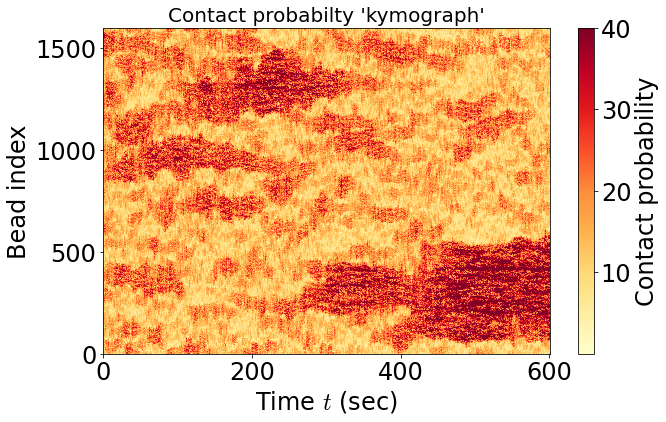

In [32]:
h5_contact_file = sim_path / 'analysis/contact_analysis.h5'

fig, axarr = plt.subplots(1,1, figsize=(10, 6))
_ = axarr.set_ylim(0, 1600)

with h5py.File(h5_contact_file, 'r') as h5_data:
    time_arr = h5_data['time'][...]
    contact_kymo = h5_data['contact_kymo'][...]
    
    cgf.plot_contact_kymo(fig, axarr, time_arr, contact_kymo, vmax=vmax)



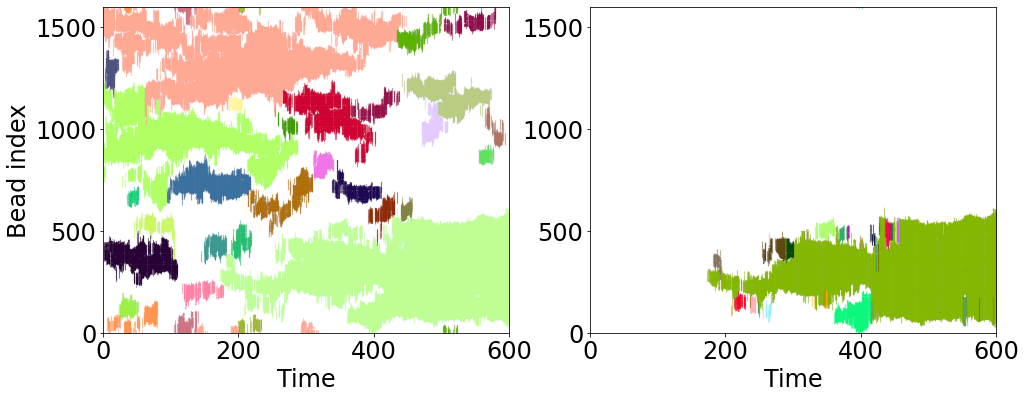

In [36]:
# Cluster analysis
h5_clust_file = sim_path / 'analysis/cluster_analysis.h5'
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        cluster_grp = [cla.Cluster(h5_data = c) for c in tg.values()]
        clusters += [[clust for clust in cluster_grp if len(clust.part_ids) > 50]]
t4 = time.time()
root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]

fig, axarr = plt.subplots(1,2, figsize=(16, 6))

# Graph all clusters
for tree, color in zip(trees, colors):
    if len(tree.clusters) < tree_length:
        continue
    for clust in tree.clusters:
        _ = axarr[0].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = color, markersize= .1, marker='.', linestyle='None')

# Graph largest branch
biggest_tree = max(trees, key=lambda x: x.get_main_clust_branch()[0].mass_hist)
biggest_tree.update_branch_roots()
branch_roots = biggest_tree.get_branch_roots()

for root, color in zip(branch_roots, colors):
    branch_clusters = root.get_largest_branch()
    for clust in branch_clusters:
        _ = axarr[1].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = color, markersize= .1, marker='.', linestyle='None')


_ = axarr[0].set_ylabel("Bead index")
for ax in axarr:
    _ = ax.set_ylim(0, 1600)
    _ = ax.set_xlim(0, time_arr[-1])
    _ = ax.set_xlabel("Time")

### 3um super sticky beads

In [37]:
data_path = ceph_path / "DynCondPaper/23-12-12_aLc1_scan8.7._line1600_PBC1-7um_Ke.1-300"
sim_path = data_path / "simulations/Ke300_Box3.0um/"

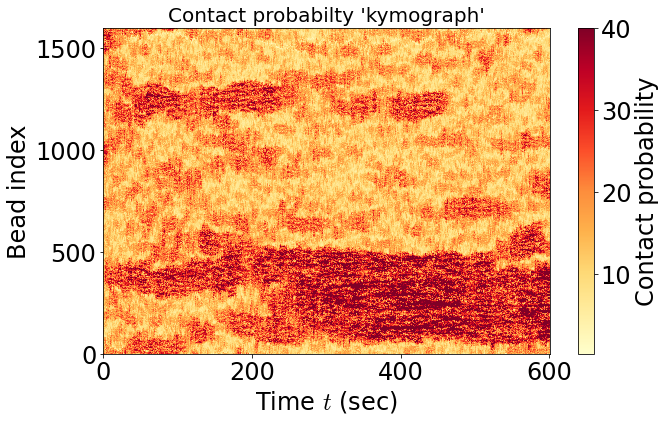

In [38]:
h5_contact_file = sim_path / 'analysis/contact_analysis.h5'

fig, axarr = plt.subplots(1,1, figsize=(10, 6))
_ = axarr.set_ylim(0, 1600)

with h5py.File(h5_contact_file, 'r') as h5_data:
    time_arr = h5_data['time'][...]
    contact_kymo = h5_data['contact_kymo'][...]
    
    cgf.plot_contact_kymo(fig, axarr, time_arr, contact_kymo, vmax=vmax)



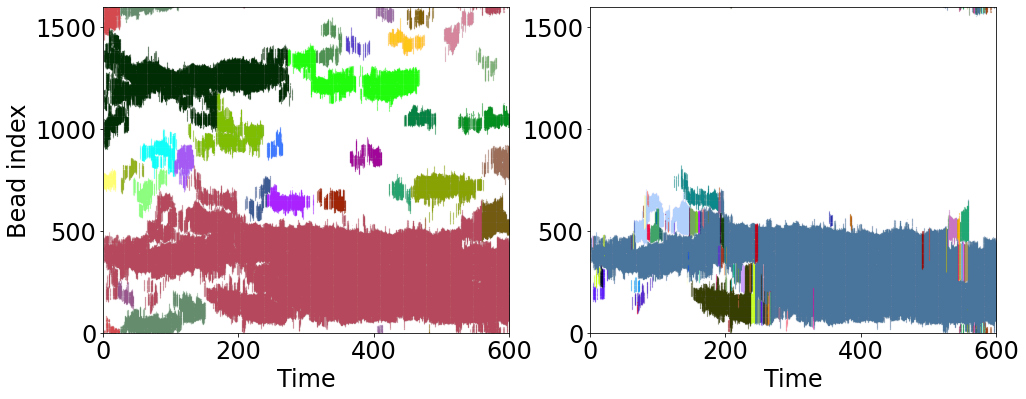

In [39]:
# Cluster analysis
h5_clust_file = sim_path / 'analysis/cluster_analysis.h5'
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        cluster_grp = [cla.Cluster(h5_data = c) for c in tg.values()]
        clusters += [[clust for clust in cluster_grp if len(clust.part_ids) > 50]]
t4 = time.time()
root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]

fig, axarr = plt.subplots(1,2, figsize=(16, 6))

# Graph all clusters
for tree, color in zip(trees, colors):
    if len(tree.clusters) < tree_length:
        continue
    for clust in tree.clusters:
        _ = axarr[0].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = color, markersize= .1, marker='.', linestyle='None')

# Graph largest branch
biggest_tree = max(trees, key=lambda x: x.get_main_clust_branch()[0].mass_hist)
biggest_tree.update_branch_roots()
branch_roots = biggest_tree.get_branch_roots()

for root, color in zip(branch_roots, colors):
    branch_clusters = root.get_largest_branch()
    for clust in branch_clusters:
        _ = axarr[1].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = color, markersize= .1, marker='.', linestyle='None')


_ = axarr[0].set_ylabel("Bead index")
for ax in axarr:
    _ = ax.set_ylim(0, 1600)
    _ = ax.set_xlim(0, time_arr[-1])
    _ = ax.set_xlabel("Time")

In [17]:
data_path = ceph_path / "DynCondPaper/23-12-12_aLc1_scan8.7._line1600_PBC1-7um_Ke.1-300"
h5_list = list(data_path.glob('simulations/*/analysis/raw*.h5'))
print(len(h5_list))
data_dict = {}
for h5d in h5_list:
    with h5py.File(h5d, 'r') as h5_data:
        run_params = yaml.safe_load(h5_data.attrs['RunConfig'])
        prot_params = yaml.safe_load(h5_data.attrs['ProteinConfig'])
        contact_file = h5d.parent / 'contact_analysis.h5'

        pin_dist = run_params['Box']
        Ke = prot_params['proteins'][0]['Ke'][1]

        if pin_dist not in data_dict:
            data_dict[pin_dist] = {}
        data_dict[pin_dist][Ke]= contact_file

pin_dist_list = sorted(data_dict.keys())
print("pin_dist_list: ", pin_dist_list)
ke_list = sorted(data_dict[pin_dist].keys())
print("ke_list: ", ke_list)

56
pin_dist_list:  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
ke_list:  [0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0, 300.0]


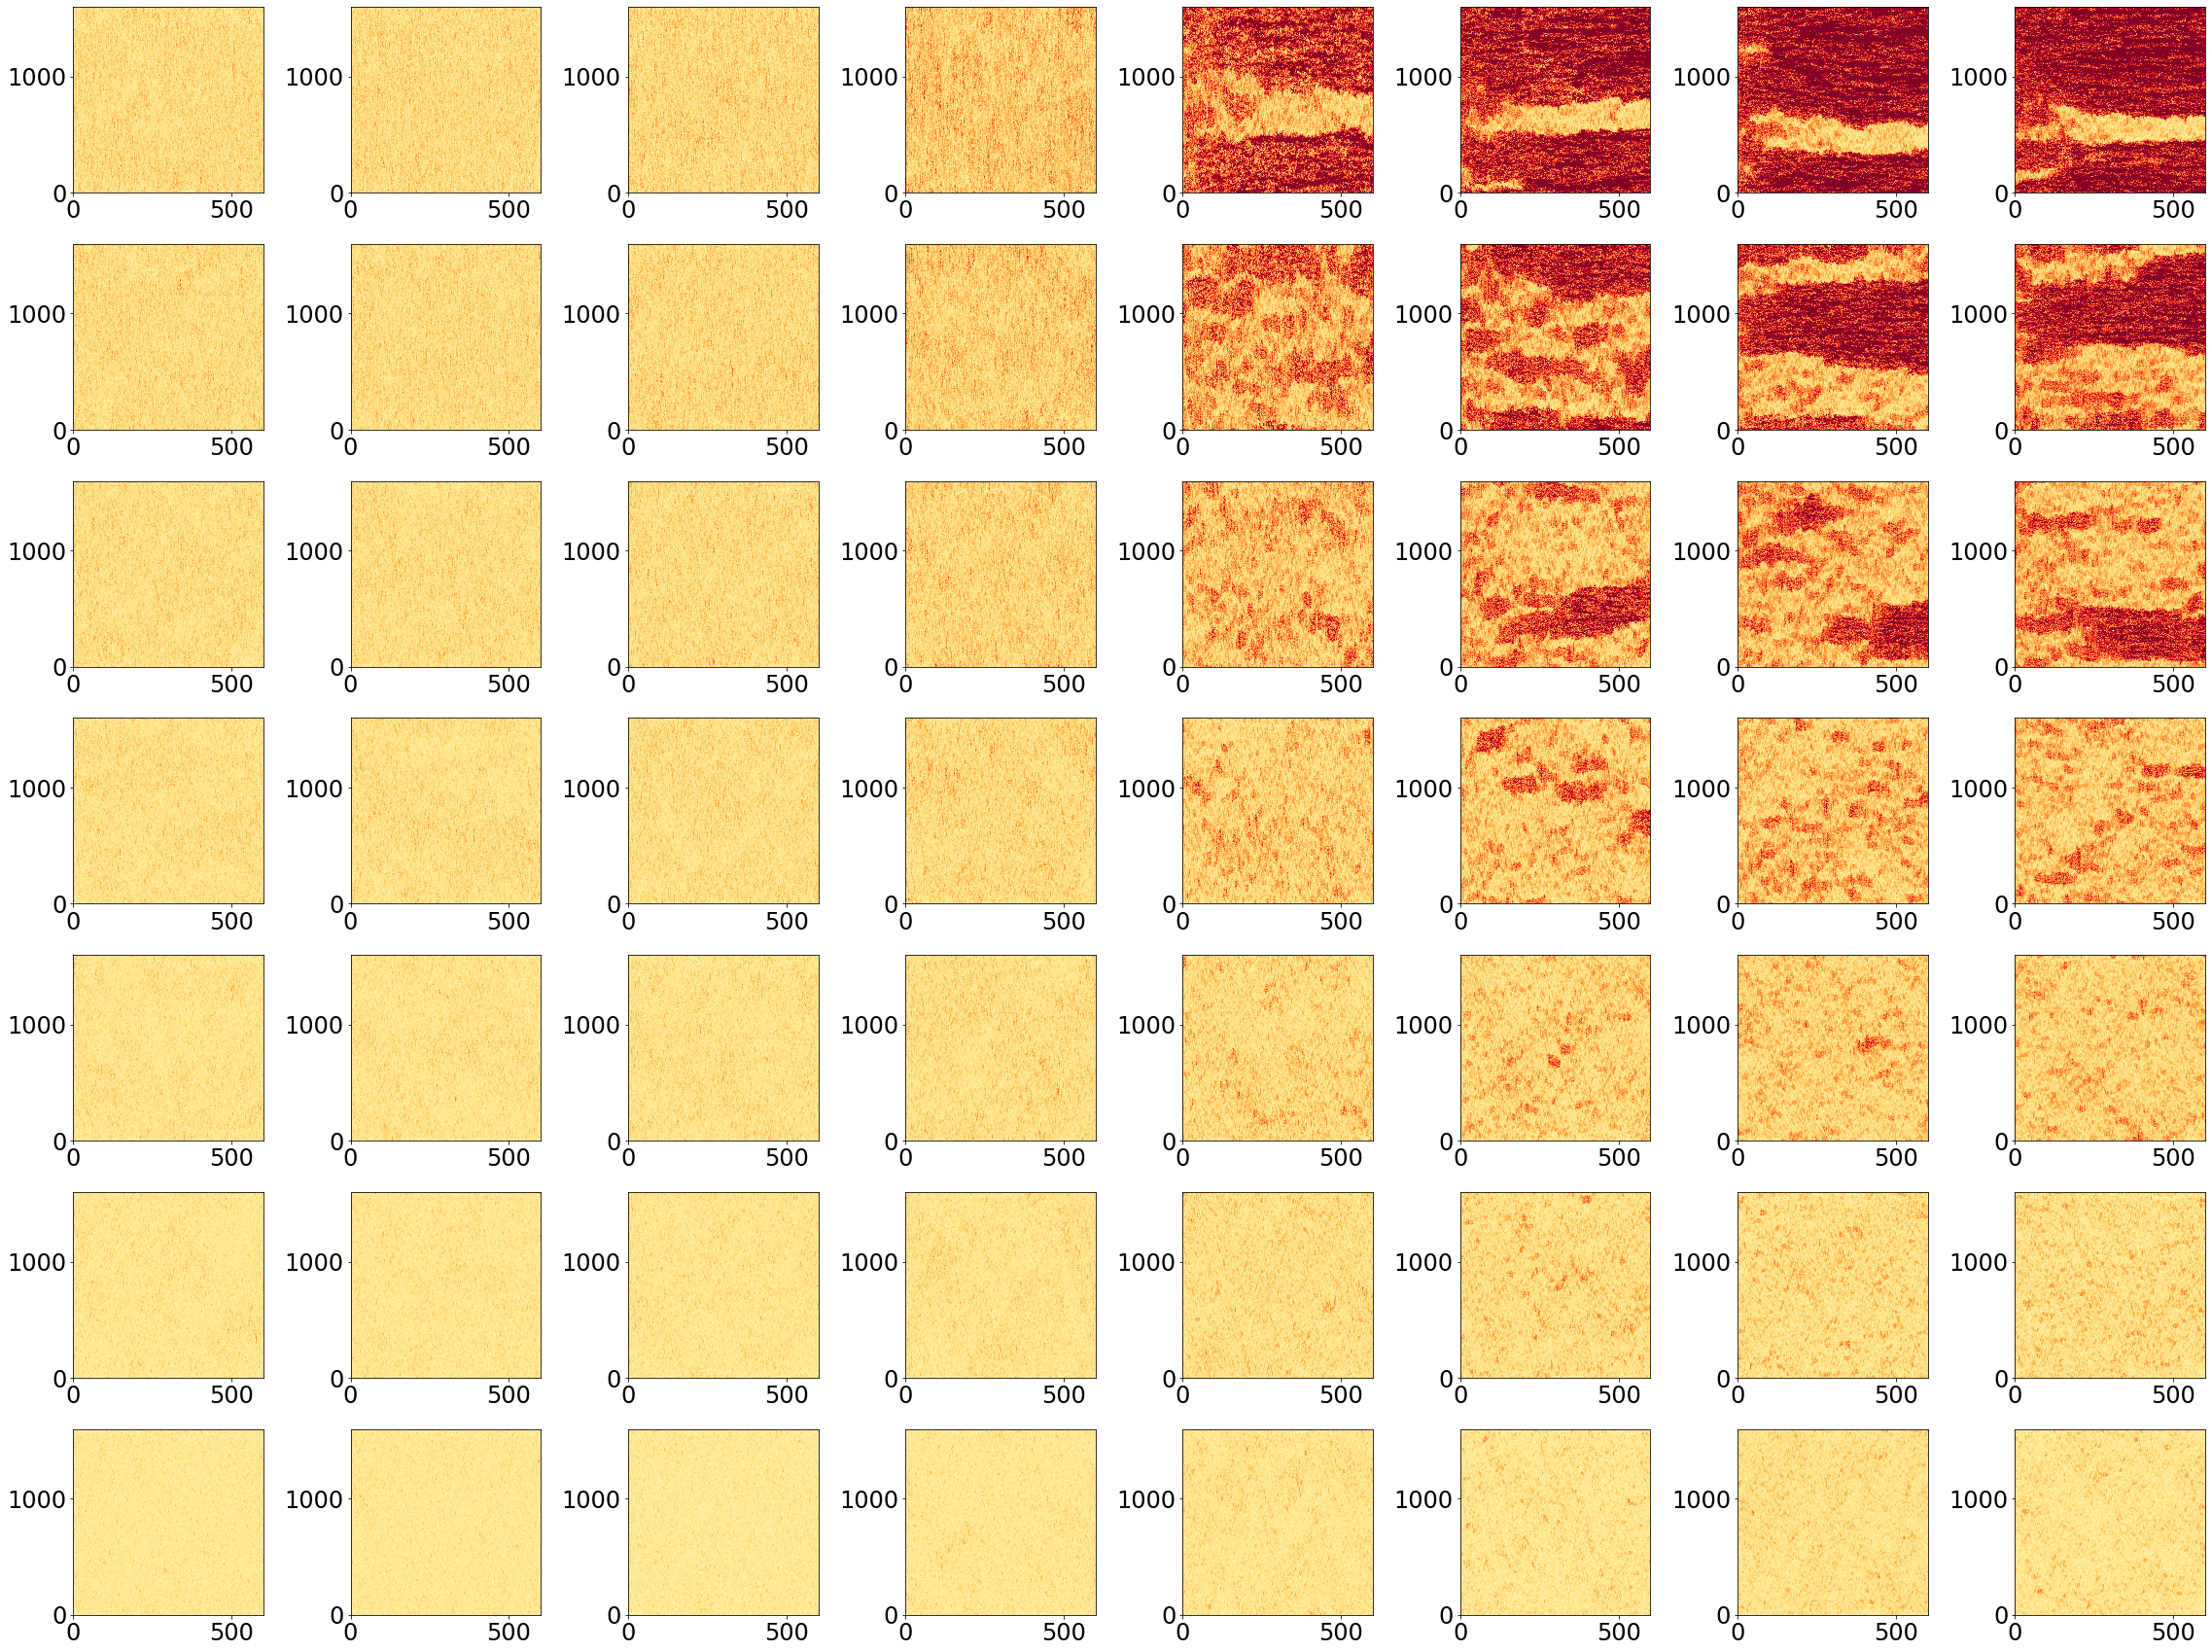

In [18]:
fig, axarr = plt.subplots(len(pin_dist_list),len(ke_list), figsize=(32, 24))
theta_arr = np.linspace(0, np.pi, 1000)
for i, pin_dist in enumerate(pin_dist_list):
    for j, ke in enumerate(ke_list):
        try: 
            with h5py.File(data_dict[pin_dist][ke], 'r') as h5_data:
                time_arr = h5_data['time'][...]
                contact_kymo = h5_data['contact_kymo'][...]
    
            cgf.plot_contact_kymo(fig, axarr[i,j], time_arr, 
                                  contact_kymo, vmax=vmax, label_flag=False)
        except:
            pass
fig.tight_layout()